In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import datetime

## Описание колонок в дата-фрейме:

1) id - уникальный ID записи
2) date_created - дата и время создания заказа
3) order_id - уникальный ID заказа
4) city_name - город заказа
5) date_assembly_started - дата и время начала сборки заказа
6) work_place_id - id места работника, который работает с заказом
7) date_picked - дата и время окончания отбора позиций заказа
8) single_item (булевое значение) - находится ли в заказе 1 товар в количестве 1 штука
9) from_multi_stock_wave (булевое значение) - собирается ли заказ с нескольких складов



## Задачи
### 1) Получить среднее время от создания заказа до начала сборки; среднее время от начала сборки заказа до окончания отбора позиций.
### 2) Для пункта выше - посчитать индекс аффинитивности.
### 3) Посмотреть динамику кол-ва заказов по городам и общую динамику и ответить на вопрос: какие города развиваются более динамично - предложить возможные причины динамики.
### 4) Проверить гипотезу: связана ли загруженность склада (кол-во созданных заказов) со временем сборки заказа?
### 5) Сегментировать города по произвольному кол-ву количественных признаков: обосновать логику сегментации и предложить модели работы с каждым сегментом.

In [5]:
uploaded = files.upload()

Saving Step_1_Uzum_Academy.csv to Step_1_Uzum_Academy.csv


In [10]:
#read csv
df = pd.read_csv('Step_1_Uzum_Academy.csv')
df = df.drop(['Unnamed: 0','dp_id'], axis = 1)
df = df.dropna()

# разделяем колонку city_name на 3 колонки city_name_ru city_name_uz place
df[['map','place']] = df['city_name'].apply(lambda x: pd.Series(str(x).split("} ")))
df['map'] = df['map'].apply(lambda x: x + '}')
import json

# преобразуем в обьект python
def try_parse_json(x):
    try:
        return json.loads(x)
    except json.JSONDecodeError:
        return {}

df['map'] = df['map'].apply(try_parse_json)
# вытаскиваем значения из словаря
df['city_name_ru'] = df['map'].apply(lambda x: x.get('ru', ''))
df['city_name_uz'] = df['map'].apply(lambda x: x.get('uz', ''))

# удаляем лишнее
df = df.drop(['map','city_name'],axis = 1)
df.dropna(inplace=True)

# приводим к временному типу данных
df['date_created'] = pd.to_datetime(df['date_created'])
df['date_assembly_started'] = pd.to_datetime(df['date_assembly_started'])
df['date_picked'] = pd.to_datetime(df['date_picked'])

# переименовываем
df.rename(columns={"date_assembly_started": "date_picked",
                   "date_picked": "date_assembly_started"})

# меняем местами в таблице(для удобства)
df['date_assembly_started'], df['date_picked'] = df['date_picked'] , df['date_assembly_started']

# создаем новые признаки,длительности этапов
df['assembly_start_delay'] = df['date_assembly_started'] - df['date_created']
df['assembly_duration'] = df['date_picked'] - df['date_assembly_started']
df['full_time'] = df['date_picked'] - df['date_created']

# переводим в секунд
df['assembly_start_delay'] = df['assembly_start_delay'].dt.total_seconds()
df['assembly_duration'] = df['assembly_duration'].dt.total_seconds()
df['full_time'] = df['full_time'].dt.total_seconds()
# переводим в дату
df['date_created'] = pd.to_datetime(df['date_created']).dt.date

# группируем датафрейм по интересующимся нам признакам
count_df = (df.groupby(['date_created','city_name_ru'],as_index=False)
      .agg({'assembly_start_delay': 'mean',
            'assembly_duration':    'mean',
            'full_time':            'mean',
            'order_id':             'count',
            'work_place_id':        'count'}))

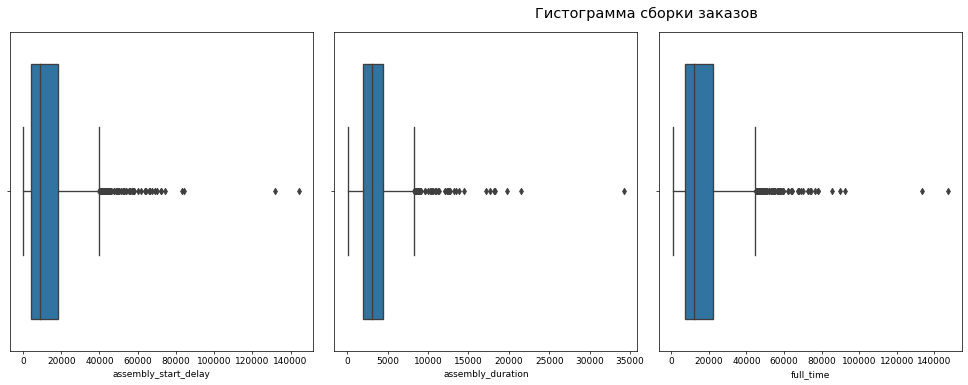

array([[<Axes: title={'center': 'assembly_start_delay'}>,
        <Axes: title={'center': 'assembly_duration'}>],
       [<Axes: title={'center': 'full_time'}>, <Axes: >]], dtype=object)

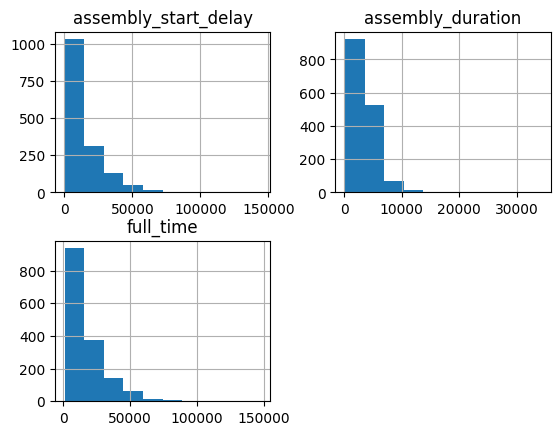

In [45]:
#
plt.figure(figsize=(20, 6), dpi=65)
plt.suptitle('Гистограмма сборки заказов', fontsize=16)

for i, col in enumerate(count_df[['assembly_start_delay','assembly_duration','full_time']], start=1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=count_df, x = col)


plt.tight_layout()
plt.show()

count_df[['assembly_start_delay','assembly_duration','full_time']].hist()

# избавляемся от выбросов
count_df.loc[count_df['assembly_start_delay'] > 80000, 'assembly_start_delay'] = count_df['assembly_start_delay'].mean()
count_df.loc[count_df['assembly_duration'] > 15000, 'assembly_duration'] = count_df['assembly_duration'].mean()
count_df.loc[count_df['full_time'] > 80000, 'full_time'] = count_df['full_time'].mean()

count_df.loc[count_df['assembly_start_delay'] <  count_df['assembly_start_delay'].quantile(0.20), 'assembly_start_delay'] = count_df['assembly_start_delay'].mean()
count_df.loc[count_df['assembly_duration'] <     count_df['assembly_duration'].quantile(0.20), 'assembly_duration'] = count_df['assembly_duration'].mean()
count_df.loc[count_df['full_time'] <             count_df['full_time'].quantile(0.20), 'full_time'] = count_df['full_time'].mean()

mean_df = count_df.groupby('city_name_ru')[['assembly_start_delay','assembly_duration','full_time']].mean().reset_index()

# строим AFF для assembly_start_delay
mean_df['AFF_delay'] = mean_df['assembly_start_delay'] / mean_df['assembly_start_delay'].mean().round(2)

# строим AFF для assembly_duration
mean_df['AFF_duration'] = mean_df['assembly_duration'] / mean_df['assembly_duration'].mean().round(2)

# строим AFF для assembly_duration
mean_df['AFF_duration'] = mean_df['full_time'] / mean_df['full_time'].mean().round(2)

# разделяем города на сегменты
mean_df['assembly_start_delay_q'] = np.where(mean_df['assembly_start_delay'] < mean_df['assembly_start_delay'].quantile(0.33), 'first',
                           np.where((mean_df['assembly_start_delay'] < mean_df['assembly_start_delay'].quantile(0.66)) & (mean_df['assembly_start_delay'] > mean_df['assembly_start_delay'].quantile(0.33)), 'second', 'third'))

mean_df['assembly_duration_q'] = np.where(mean_df['assembly_duration'] < mean_df['assembly_duration'].quantile(0.33), 'first',
                           np.where((mean_df['assembly_duration'] < mean_df['assembly_duration'].quantile(0.66)) & (mean_df['assembly_duration'] > mean_df['assembly_duration'].quantile(0.33)), 'second', 'third'))

mean_df['full_time_q'] = np.where(mean_df['full_time'] < mean_df['full_time'].quantile(0.33), 'first',
                           np.where((mean_df['full_time'] < mean_df['full_time'].quantile(0.66)) & (mean_df['full_time'] > mean_df['full_time'].quantile(0.33)), 'second', 'third'))
# получаем финальные группы
mean_df['quanitle_rate'] = mean_df['assembly_start_delay_q'] + '_' + mean_df['assembly_duration_q'] + '_' + mean_df['full_time_q']

In [80]:
mean_df.describe()

,assembly_start_delay,assembly_duration,full_time,AFF_delay,AFF_duration
count,65.000000,65.000000,65.000000,65.000000,65.000000
mean,12881.378933,3781.483016,16677.942263,1.000000,1.000000
std,7382.646525,1435.386264,7968.193244,0.573125,0.477768
min,2742.924001,1359.921568,5827.600060,0.212937,0.349420
25%,8911.314523,3287.430716,12791.240397,0.691798,0.766956
50%,11620.114985,3562.015642,15091.321009,0.902086,0.904867
75%,14183.297498,3964.945782,17986.461072,1.101070,1.078458
max,55284.195368,12046.026279,63693.574870,4.291791,3.819031


In [83]:
avg_df = mean_df.groupby('quanitle_rate').agg({'assembly_start_delay': 'mean',
                                               'assembly_duration': 'mean',
                                               'full_time': 'mean',
                                               'assembly_start_delay': 'std',
                                               'assembly_duration': 'std',
                                               'full_time': 'std'}).reset_index()
avg_df.head(20)

,quanitle_rate,assembly_start_delay,assembly_duration,full_time
0,first_first_first,1967.083905,564.237007,2106.555188
1,first_first_third,NaN,NaN,NaN
2,first_second_first,899.820861,126.032987,602.743870
3,first_third_first,840.014871,294.749252,2121.795323
4,first_third_second,NaN,NaN,NaN
5,second_first_second,22.591587,472.789219,68.309599
6,second_second_first,397.845460,62.112368,307.854811
7,second_second_second,779.799827,99.453547,942.136540
8,second_third_second,635.475546,684.853430,807.831723
9,second_third_third,NaN,NaN,NaN


In [82]:
avg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, first_first_first to third_third_third
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   assembly_start_delay  10 non-null     float64
 1   assembly_duration     10 non-null     float64
 2   full_time             10 non-null     float64
dtypes: float64(3)
memory usage: 1.0+ KB


1. Написать кластерный анализ (Даниэль)
2. Проверить гипотезу загруженности склада и ее влияние на время сборки заказа (Даниэль)

3. Почитать про ЦПТ (Тима)
4. Прочитать про параметрические и непараметрические методы сравнения: в чем разница, основные предположения и тп (Тима)
5. Кластерный анализ (k-means) (Тима)
6. Предположить некоторое кол-во гипотез почему группы именно такие и почему города могут различаться. = > запланировать следующие шаги